In [1]:
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm, tqdm_notebook
import tarfile
import zipfile
import warnings
from aux import *
from PIL import Image
import PIL
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import wget

tqdm.monitor_interval = 0
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


### Download DataSet

url_de = 'http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads/'
r = requests.get(url_de)
soup = BeautifulSoup(r.content, 'html.parser')

# Only get the url of files to downloas
urls = [href(url) for url in soup.findAll('a') if 'download' in url.text.lower()][2:-3]

# remove the first backSlash that does not appear in all the urls
urls = [url[1:] if url.startswith('/') else url for url in urls]

# Only keep the final train test Urls
urls = [url for url in urls if 'Final' in url]

# Create the Folder if it doesn't exist
data_dir = 'Data/Germany/'
create_dir(data_dir)

# Download all the data
for url in tqdm(urls) : 
    wget.download('http://benchmark.ini.rub.de/' + url, data_dir)

files = os.listdir(data_dir)

for file in tqdm(files) : 
    extract_zip(data_dir, file)

## X and Y creation

# Current directory for training data
data_dir = 'Data/Germany/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/'

filenames = [file  for file in sorted(os.listdir(data_dir)) if not(file.startswith("."))]
file_images = [sorted(os.listdir(data_dir + file)) for file in filenames]

# Create an array with only the image for train (without meta data) and also the test 
images = []
X = []
Y = np.array([])

for files in file_images :
    
    # Get the index of the directory (class number from 0 to 42)
    index_file = file_images.index(files)
    
    # Get the file name of all the images of the current class
    to_add = [file for file in files if '.ppm' in file]
    images.append(to_add)
    
    # Create the Input data matrix X by reading every image of every class and concatenate them
    X.extend(np.array([np.asarray(Image.open('{}{}/{}'.format(data_dir,filenames[index_file],file_images[index_file][to_add.index(image)]))) for image in to_add]))

    # Create the Labels of the current class of images and concatenate it with already stored class id's
    y = np.empty(len(to_add))
    y.fill(index_file)
    Y = np.concatenate((Y,y), axis = 0)

## Save the Data in Pickle files
with open("X.obj","wb") as f :
    pickle.dump(X, f)
    
with open("Y.obj", "wb") as f :
    pickle.dump(Y, f)

In [2]:
## Save the Data in Pickle files
with open("X.obj","rb") as f :
    X_ = pickle.load(f)
    
with open("Y.obj", "rb") as f :
    Y_ = pickle.load(f)

In [3]:
# Get the trafic sign name of the corresponding label
class_toSign = pd.read_csv(wget.download('https://raw.githubusercontent.com/hediD/ada-assignments/master/signnames.csv'))
class_toSign

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


## Data Exploration

Let's count the number of elements in each class

In [4]:
X_resized = [np.asarray((Image.fromarray(X_[i])).resize((32, 32), PIL.Image.ANTIALIAS)) for i in range(len(X_))]

In [7]:
count_dict = {}
for elem in list(set(Y_)) :
    count_dict[int(elem)] = np.count_nonzero(Y_ == elem)
    

# Compute the percentage of training example of each class compared to the total number
count_pd = pd.Series(count_dict)
#pct_train = count_pd.apply(lambda x : '{} %'.format(round(x / count_pd.sum() * 100, 2)))
pct_train = count_pd.apply(lambda x : round(x / count_pd.sum() * 100, 2))

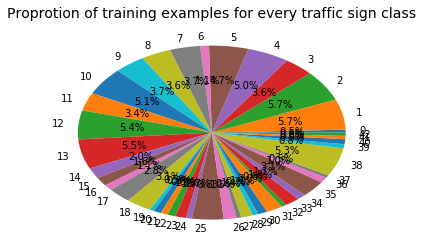

In [8]:
plt.clf()
plt.pie(pct_train, labels=list(count_dict.keys()), autopct= lambda x: str(round(x,1)) + '%')
plt.title("Proprotion of training examples for every traffic sign class", fontsize = 14)
plt.show()

We can see that there is unbalanced number of Images between the different classes

### Data Augmentation

In [136]:
from aux_images.py import *

ModuleNotFoundError: No module named 'aux_images'

In [ ]:
images_toShow = []

# Loop over all classes
for i in range(len(count_dict)) :
    
    # Get the first element of the current class
    curr_index = count_pd.iloc[:i].sum()
    
    # Get a list of the sum of pixel values for each image of the current class
    images_dim = [np.sum(X_[j]) for j in range(curr_index, curr_index + count_dict[i])]
    
    # Add the brightest image (in pixels) to the images to show
    images_toShow.append(X_[curr_index + np.argmax(images_dim)])

<Figure size 432x288 with 0 Axes>

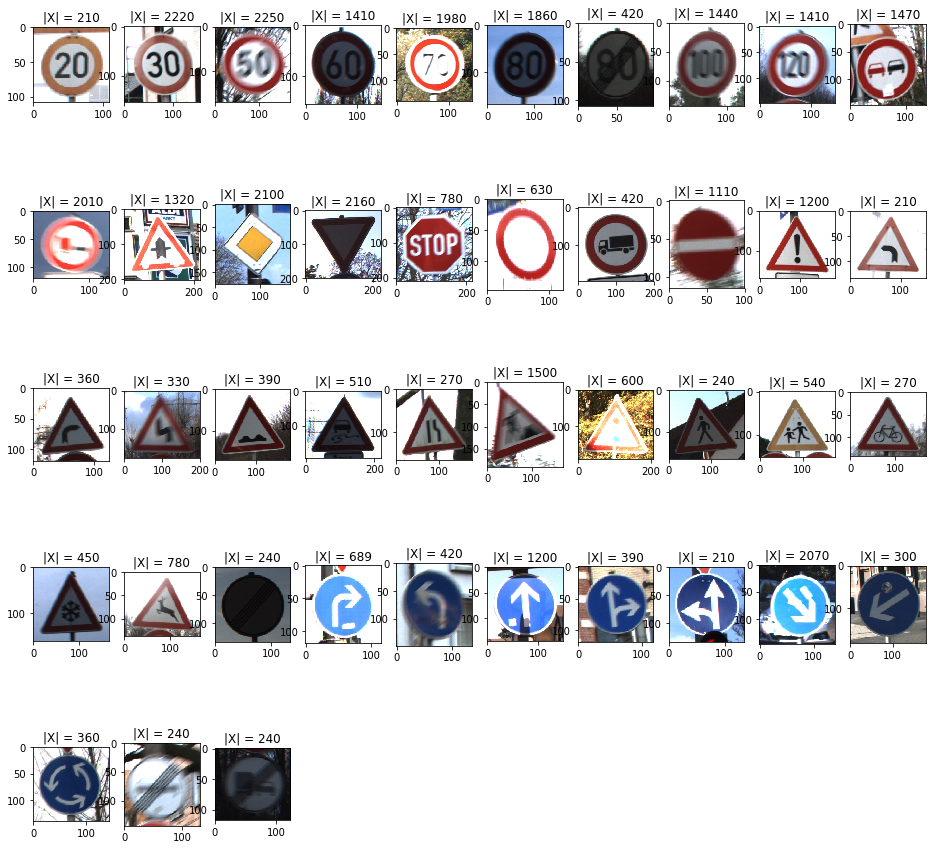

In [14]:
plt.clf()
fig = plt.figure(figsize=(16, 16))
columns = 10
rows = 5
for i in range(1, len(images_toShow) + 1):
    fig.add_subplot(rows, columns, i, title = "|X| = {}".format(count_dict[i-1]))
    plt.imshow(images_toShow[i-1])
plt.show()

Let's augment the data of the classes that have fewer number of examples 

### Flip 

In [57]:
X_extended, Y_extended = image_flip(np.array(X_resized), np.array(Y_))

### Change brightess

In [173]:
X_bright, Y_bright = np.array([augment_brightness_camera_images(X_extended[i]) for i in range(len(X_extended))]), Y_extended.copy()

### Rotation not working yet !! 

- x_image = Image.fromarray(x).rotate(20, expand=True)
- apply_projection_transform_(x, 0.75)

## Final DataSet

In [193]:
# Concatenate all the data augmentations techniques used on the original images
X_all = np.vstack((X_extended,X_bright))
Y_all = np.hstack((Y_extended, Y_bright))

In [196]:
## Save final 
with open("X_final.obj","wb") as f :
    pickle.dump(X_all, f)
    
with open("Y_final.obj", "wb") as f :
    pickle.dump(Y_all, f)